<a href="https://colab.research.google.com/github/akashsinghsharma/Retail-Sales-Prediction/blob/main/Retail_Sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Frame the problem

This is going to be a Data Analaysis and Machine learning project. I will use python to answer multiple question that the stakeholder might ask, and ML to predict the sales for next 6 weeks in advance.


**Problem Description**

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

In [2]:
# pip install pyforest

  Preparing metadata (setup.py) ... done
  Created wheel for pyforest: filename=pyforest-1.1.0-py2.py3-none-any.whl size=14608 sha256=dd8eb6a8b734c9f9249e8bcaa17287114306093d05bb68869d98c2cb1d2b5203
  Stored in directory: /root/.cache/pip/wheels/9e/7d/2c/5d2f5e62de376c386fd3bf5a8e5bd119ace6a9f48f49df6017
Successfully built pyforest


In [3]:
import pyforest

# 2. Collecting the Data


---
Data Source: Kaggle


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
store = pd.read_csv('/content/drive/MyDrive/Random data/Sales Prediction/store.csv')
train = pd.read_csv('/content/drive/MyDrive/Random data/Sales Prediction/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Random data/Sales Prediction/test.csv')

store.shape , train.shape , test.shape

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-5-a3ac20229790>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/content/drive/MyDrive/Random data/Sales Prediction/train.csv')


<IPython.core.display.Javascript object>

((1115, 10), (1017209, 9), (41088, 8))

In [6]:
store.sample(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
1002,1003,a,a,170.0,7.0,2013.0,1,27.0,2013.0,"Jan,Apr,Jul,Oct"
859,860,c,c,5980.0,2.0,2010.0,0,NaN,NaN,NaN
52,53,a,c,30360.0,9.0,2013.0,0,NaN,NaN,NaN
89,90,a,a,330.0,11.0,2007.0,0,NaN,NaN,NaN
1010,1011,a,c,490.0,9.0,2012.0,1,18.0,2011.0,"Feb,May,Aug,Nov"


In [7]:
train.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
790687,938,2,2013-07-23,7091,800,1,0,0,1
502029,1065,2,2014-04-08,3861,476,1,0,0,0
964622,933,7,2013-02-17,0,0,0,0,0,0
775752,498,1,2013-08-05,6939,868,1,0,0,1
769285,721,7,2013-08-11,0,0,0,0,0,0


In [8]:
test.sample(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
20146,20147,590,2,2015-08-25,1.0,0,0,1
29749,29750,840,5,2015-08-14,1.0,0,0,1
16293,16294,40,6,2015-08-29,1.0,0,0,0
20998,20999,586,1,2015-08-24,1.0,0,0,0
12096,12097,149,4,2015-09-03,1.0,1,0,1


**Initial Data Exploration**



---


Making some new columns for better analysis.

1. Stripping the column which contains Date into year, month, date, day and week of year column. This will help us better understand seasonality as this is a time series data.

2. Making a new column: Sale per customer = Sales / customer.

In [20]:
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month
train['Day'] = pd.DatetimeIndex(train['Date']).day
train['WeekofYear'] = pd.DatetimeIndex(train['Date']).dayofweek

train['SalesPerCustomer'] = train['Sales']/train['Customers']

train.sample(5)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekofYear,SalesPerCustomer
848790,1061,6,2013-06-01,6470,523,1,0,0,0,2013,6,1,5,12.370937
41764,510,3,2015-06-24,7243,778,1,0,0,0,2015,6,24,2,9.309769
79670,506,4,2015-05-21,7671,850,1,1,0,0,2015,5,21,3,9.024706
225563,334,6,2015-01-10,4616,512,1,0,0,0,2015,1,10,5,9.015625
808224,635,7,2013-07-07,0,0,0,0,0,0,2013,7,7,6,NaN


**Initial Data Exploration**

---



**EDA**

---

1. **Store close or open**

Notice that in open column, it is 0 when the store is closed.Let's see when is it usually closed wrt day of week.

In [10]:
closed_df = train[train['Open'] == 0]
closed_df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
225197,1083,7,2015-01-11,0,0,0,0,0,0
200942,243,7,2015-02-01,0,0,0,0,0,0
920138,1049,5,2013-03-29,0,0,0,1,b,1
573500,61,7,2014-02-02,0,0,0,0,0,0
235839,575,4,2015-01-01,0,0,0,0,a,1


array([[<Axes: title={'center': 'DayOfWeek'}>]], dtype=object)

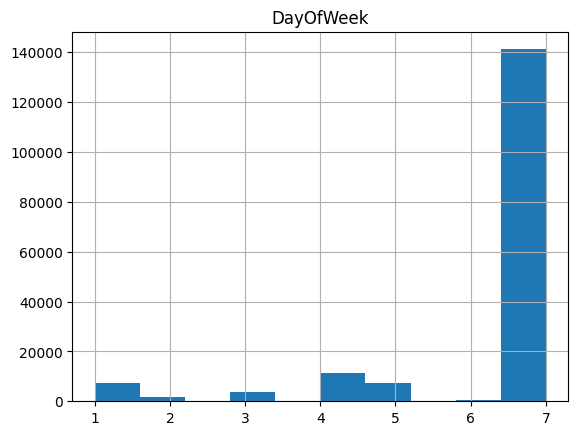

In [11]:
closed_df.hist('DayOfWeek')